In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
# nltk.download()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [2]:
wine = pd.read_csv('redwine.csv', delimiter=';')
chemColNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
chem = wine[chemColNames]

colErrorPairs = {
    'density'    : [' . '],
    'citric acid': [' - ',' -   '],
    'alcohol'    : ['100.333.333.333.333','11.066.666.666.666.600','956.666.666.666.667','923.333.333.333.333']}

for colName in colErrorPairs:
    for faultyString in colErrorPairs[colName]:
        wine[colName] = wine[colName].replace(faultyString,np.nan)
        
wine['alcohol'] = wine['alcohol'].astype(float)
wine['density'] = wine['density'].astype(float)
wine['citric acid'] = wine['citric acid'].astype(float)

wine['taster_name'] = wine['taster_name'].apply(lambda name: name.split(" ")[0])

In [3]:
name = pd.read_csv('names.csv', usecols=['Name','Gender', 'Year','Count'])

# Onderzoeksvraag 2: Als we wijnen categoriseren op basis van de chemische samenstelling, zijn er bepaalde categorieën die mannelijke proevers anders beoordelen dan vrouwelijke proevers?


We willen bij deze onderzoeksvraag mannelijke en vrouwelijke proevers vergelijken door te kijken of de ene groep een bepaalde voorkeur heeft voor een bepaalde categorie wijn.

In [4]:
# name = name[name['Year'] >= 2014]
name

,Name,Year,Gender,Count
0,Mary,1880,F,7065
1,Anna,1880,F,2604
2,Emma,1880,F,2003
3,Elizabeth,1880,F,1939
4,Minnie,1880,F,1746
...,...,...,...,...
1825428,Zykeem,2014,M,5
1825429,Zymeer,2014,M,5
1825430,Zymiere,2014,M,5
1825431,Zyran,2014,M,5


In [5]:
name.sort_values(by=['Count'],ascending=False, inplace=True)
name.drop_duplicates(subset=['Name'], keep='first', inplace=True)
name.sort_values(by=['Name'], inplace=True)

Nu gaan we onze twee datasets mergen. We doen een inner join op de twee kolommen waar de namen in staan en printen de eerste 5 records. 

In [6]:
merge = wine.merge(name, left_on='taster_name', right_on='Name', how="left")
merge

,id,country,description,designation,points,price,province,taster_name,title,variety,winery,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Name,Year,Gender,Count
0,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Kerin,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,10.0,0.29,0.40,2.9,0.098,10.0,26.0,10.00600,3.48,0.91,9.7,Kerin,1981,F,43
1,2,Portugal,"From an estate in the south of the Alentejo, t...",Grande Reserva Tinto,91,26.0,Alentejano,Roger,Casa Santa Vitória 2013 Grande Reserva Tinto R...,Portuguese Red,Casa Santa Vitória,8.3,0.26,0.37,1.4,0.076,8.0,23.0,0.99740,3.26,0.70,9.6,Roger,1953,M,13155
2,3,Portugal,A year in wood and 30 months in bottle before ...,Montes Claros Garrafeira,90,28.0,Alentejo,Paul,Adega Cooperativa de Borba 2012 Montes Claros ...,Portuguese Red,Adega Cooperativa de Borba,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,Paul,1957,M,26987
3,4,Portugal,Wood aging gives this ripe blend of Baga and T...,NaN,90,20.0,Beira Atlantico,Alexander,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Portuguese Red,Quinta de Foz de Arouce,7.0,0.69,0.07,2.5,0.091,15.0,21.0,0.99572,3.38,0.60,11.3,Alexander,1993,M,20523
4,5,Portugal,"A powerful wine, richly structured and full of...",Gerações Colheita Seleccionada,92,34.0,Alentejano,Paul,Herdade Grande 2010 Gerações Colheita Seleccio...,Portuguese Red,Herdade Grande,8.0,0.48,0.34,2.2,0.073,16.0,25.0,0.99360,3.28,0.66,12.4,Paul,1957,M,26987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,2462,Portugal,"Two classic Dão grapes, Touriga Nacional and T...",Dona Georgina,93,60.0,Dão,Roger,Quinta de Lemos 2010 Dona Georgina Red (Dão),Portuguese Red,Quinta de Lemos,9.2,0.41,0.50,2.5,0.055,12.0,25.0,0.99520,3.34,0.79,13.3,Roger,1953,M,13155
2461,2463,Portugal,Old vines in a field blend give a rich structu...,Monte Cascas Grande Reserva,93,39.0,Douro,Michael,Casca Wines 2011 Monte Cascas Grande Reserva R...,Portuguese Red,Casca Wines,8.9,0.40,0.51,2.6,0.052,13.0,27.0,0.99500,3.32,0.90,13.4,Michael,1957,M,92709
2462,2464,Portugal,This rich wine has a firm structure as well as...,Pacheca Superior,90,NaN,Douro,Roger,Quinta da Pacheca 2013 Pacheca Superior Red (D...,Portuguese Red,Quinta da Pacheca,7.7,0.56,0.08,2.5,0.114,14.0,46.0,0.99710,3.24,0.66,9.6,Roger,1953,M,13155
2463,2465,Portugal,This mature wine that has 50% Touriga Nacional...,Reserva,90,NaN,Dão,Roger,Seacampo 2011 Reserva Red (Dão),Portuguese Red,Seacampo,8.1,0.53,0.22,2.2,0.078,33.0,89.0,0.99678,3.26,0.46,9.6,Roger,1953,M,13155


Nu printen we de tabel waarbij we de naam van de proever en het geslacht tonen. 

In [7]:
tasters = merge[['taster_name', 'Gender']]
tasters.head()

,taster_name,Gender
0,Kerin,F
1,Roger,M
2,Paul,M
3,Alexander,M
4,Paul,M


In [14]:
count = tasters['Gender'].value_counts()

<AxesSubplot:ylabel='Gender'>

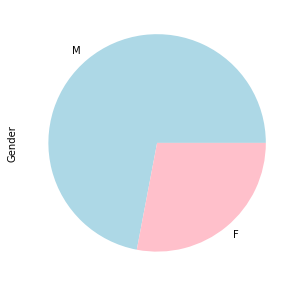

In [18]:
count.plot.pie(y ='Gender', figsize = (5,5), colors = ['lightblue', 'pink'])

## Clusteren


In [21]:
chemColNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
chem = wine[chemColNames]

kmeansData = wine[[chem]].copy()


ValueError: Index data must be 1-dimensional